In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tr = pd.read_csv('train.csv')
te = pd.read_csv('test.csv')

In [5]:
tr.shape

(33173, 17)

### Random Forest

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from math import sqrt


In [24]:
tr.columns

Index(['Unnamed: 0', 'Timestamp', 'Values', 'Temperature', 'holiday',
       'Weekday', 'Hour', 'Month', 'Day', 'Time Delta', 'value delta',
       'tv delta', 'prev value', 'twice prev value', 'day shift',
       'month shift', 'year'],
      dtype='object')

#### Initial random forest fit 

In [7]:
#selecting X and Y variables
y_train = tr['tv delta']
X_train = tr[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

y_test = te['tv delta']
X_test = te[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

In [44]:
from sklearn.preprocessing import StandardScaler

#scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# create regressor object 
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)

tr_pred = regressor.predict(X_train) 
te_pred = regressor.predict(X_test) 

print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))

print('Mean Absolute Error for train:', metrics.mean_absolute_error(y_train, tr_pred))
print('Mean Absolute Error for test:', metrics.mean_absolute_error(y_test, te_pred))

feature_list = ['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']
# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

RMSE for training set: 5.716350014724802
RMSE for test set: 15.887416299573475
Mean Absolute Error for train: 3.949370992318209
Mean Absolute Error for test: 11.002088145230802
Variable: prev value           Importance: 0.9
Variable: Temperature          Importance: 0.03
Variable: day shift            Importance: 0.03
Variable: twice prev value     Importance: 0.02
Variable: month shift          Importance: 0.02
Variable: holiday              Importance: 0.0


#### We are clearly overfitting. Let's finetune some parameters

- n_estimators: number of trees built before taking avg of predictions. In general, a higher number of trees increases the performance and makes the predictions more stable, but it also slows down the computation

- min_sample_leaf: The minimum number of samples required to be at a leaf node. A smaller leaf makes the model more prone to capturing noise in train data. We are overfitting so let's try increasing this.

source: https://builtin.com/data-science/random-forest-algorithm

In [27]:
def tuning(X_train,y_train,X_test,y_test, estimators, leaf):
    ''' This function takes a list of estimator and leaf parameters and returns 
    the parameters that produced the lowest error'''
    
    arr = np.zeros((len(estimators),len(leaf))) #empty array to store scores
    
    #scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    for i in range(len(estimators)):
        for j in range(len(leaf)):
            est = estimators[i]
            l = leaf[j]
           
             # create regressor object 
            regressor = RandomForestRegressor(n_estimators = est, min_samples_leaf=l, random_state = 0) 
  
            # fit the regressor with x and y data 
            regressor.fit(X_train, y_train)

            tr_pred = regressor.predict(X_train) 
            te_pred = regressor.predict(X_test) 

            test_score = sqrt(mean_squared_error(y_test, te_pred))
            arr[i][j] = test_score
    
   
    max_ = np.amin(arr) 
    inputs = np.where(arr == max_)
    print("Lowest test RMSE score:",max_)
    best_est = estimators[inputs[0][0]]
    best_leaf = leaf[inputs[1][0]]
    print("Best # estimators:",best_est)
    print("Best # min samples leaf:",best_leaf)

In [28]:
est = [10,100,200,300]
leaf = [15,30,50,70]
max_feats = ['auto', 'sqrt', 'log2']

arr = tuning(X_train,y_train,X_test,y_test,est,leaf)


Lowest test RMSE score: 15.140363398825533
Best # estimators: 300
Best # min samples leaf: 50


Our test RMSE dropped from the previous value of 15.88 to 15.14

Let's see if increasing both the number of estimators and min samples leaf value will help

In [29]:
est = [300,500,700]
leaf = [50,60,70]

arr = tuning(X_train,y_train,X_test,y_test,est,leaf)

Lowest test RMSE score: 15.140363398825533
Best # estimators: 300
Best # min samples leaf: 50


300 and 50 is our best bet. Let's see whether 200 will perform as well as 300. 

In [30]:
regressor = RandomForestRegressor(n_estimators = 200, min_samples_leaf=50, random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)

tr_pred = regressor.predict(X_train) 
te_pred = regressor.predict(X_test) 

print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))

RMSE for training set: 14.570057072199504
RMSE for test set: 15.143103582113675


Let's stick with our parameters of 200 and 50. Next, let's adjust for the max_features parameter (the maximum number of features random forest considers to split a node). The default max_features is 'auto' so we will try 'sqrt' and 'log2' to see if test RMSE improves. 

In [31]:
from sklearn.preprocessing import StandardScaler

def RF_Fit(X_train,y_train,X_test,y_test,num_estimators,min_samples_leafs,max_feat):
    
    #scaling the data
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    
     # create regressor object 
    regressor = RandomForestRegressor(n_estimators = num_estimators, min_samples_leaf=min_samples_leafs, max_features = max_feat, random_state = 0) 
  
    # fit the regressor with x and y data 
    regressor.fit(X_train, y_train)

    tr_pred = regressor.predict(X_train) 
    te_pred = regressor.predict(X_test) 
    
    print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
    print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))

In [32]:
RF_Fit(X_train,y_train,X_test,y_test,200,50,'sqrt')

RMSE for training set: 15.175714465966099
RMSE for test set: 15.141332288735486


In [33]:
RF_Fit(X_train,y_train,X_test,y_test,200,50,'log2')

RMSE for training set: 15.175714465966099
RMSE for test set: 15.141332288735486


The default for max_features is 'auto'. If we recall from above, this achieved a test RMSE of 15.14 and train RMSE of 14.57 All of these models perform equally well. There is a small difference in the error for test and training set - indicating our model has found the sweet spot in the bias variance trade-off. Log2 and sqrt both diminish the variance of our model. Let's just stick with log2


#### Separating weekends and weekdays to see if it improves model performance

In [34]:
weekday = [0,1,2,3,4]
weekday_tr = tr[tr['Weekday'].isin(weekday)]
weekday_te = te[te['Weekday'].isin(weekday)]

In [35]:
#selecting X and Y variables
y_train = weekday_tr['tv delta']
X_train = weekday_tr[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

y_test = weekday_te['tv delta']
X_test = weekday_te[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

In [36]:
RF_Fit(X_train,y_train,X_test,y_test,200,50,'log2')

RMSE for training set: 16.27732440729296
RMSE for test set: 15.769662053532306


The model performed worse on weekday data alone. Let's leave the weekdays and weekends together. 

### XGBoost 

Can we improve our model's performance?


Random Forest achieved:
- RMSE for training set: 15.175714465966099
- RMSE for test set: 15.141332288735486

In [37]:
import xgboost as xgb

In [38]:
#selecting X and Y variables
y_train = tr['tv delta']
X_train = tr[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

y_test = te['tv delta']
X_test = te[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

In [39]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)
# model training
params = {'seed': 33,
          'objective': 'reg:squarederror',
          'silent': 0,
          'nthread': 1,
          'max_depth': 2,
          'learning_rate': 0.1}
num_round = 5000
evallist = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=50)
tr['pred'] = bst.predict(xgb.DMatrix(X_train))
te['pred'] = bst.predict(xgb.DMatrix(X_test))

[11:54:13] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:130.23007	eval-rmse:110.43436
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 50 rounds.
[1]	train-rmse:117.69630	eval-rmse:98.91894
[2]	train-rmse:106.45283	eval-rmse:89.29782
[3]	train-rmse:96.31318	eval-rmse:80.06074
[4]	train-rmse:87.21256	eval-rmse:71.87453
[5]	train-rmse:79.04758	eval-rmse:64.67923
[6]	train-rmse:71.70111	eval-rmse:58.65943
[7]	train-rmse:65.12905	eval-rmse:53.10919
[8]	train-rmse:59.23132	eval-rmse:48.04398
[9]	train-rmse:53.96944	eval-rmse:43.51214
[10]	train-rmse:49.25400	eval-rmse:39.7

The random forest model actually performed better than XGBoost. 
XGBoost had the following metrics:
- train-rmse:15.26746	
- test-rmse:15.22363

### Testing a neural net

In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor


from sklearn.preprocessing import StandardScaler
y_train = tr['tv delta']
X_train = tr[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

y_test = te['tv delta']
X_test = te[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

#scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

mlp = MLPRegressor(solver = 'adam',max_iter = 5000, batch_size = 64, learning_rate_init = 0.005 )

mlp.fit(X_train,y_train)



#add in dropout 

MLPRegressor(activation='relu', alpha=0.0001, batch_size=64, beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.005, max_fun=15000, max_iter=5000,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

In [7]:
import numpy as np
from math import sqrt

tr_pred = mlp.predict(X_train) 
te_pred = mlp.predict(X_test) 
    
print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))

RMSE for training set: 15.151045905727592
RMSE for test set: 15.038969083530885


Best random forest:
- RMSE for training set: 15.1757
- RMSE for test set: 15.1413
- Difference = 0.0344

XGBoost:
- train-rmse:15.26745
- test-rmse:15.2236
- Difference = 0.0438

NN before hypertuning parameters
- RMSE for training set: 15.1510
- RMSE for test set: 15.0389
- Difference = 0.1121

NN after hypertuning round 1: 
- RMSE for training set: 14.739
- RMSE for test set: 15.169
- Difference: 0.57

NN after hypertuning round 2:
- RMSE for training set: 15.2652
- RMSE for test set: 15.2569
- Difference: 0.0083

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

param_grid = [
        {
            'activation' : ['tanh', 'relu'],
            'solver' : ['adam'],
            'hidden_layer_sizes': [(5,),(15,),(50,)],
            'batch_size': [20,60,100],
            'max_iter' : [5000]
        }
       ]

clf = GridSearchCV(MLPRegressor(), param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
clf.fit(X_train,y_train)




print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'activation': 'tanh', 'batch_size': 20, 'hidden_layer_sizes': (50,), 'max_iter': 5000, 'solver': 'adam'}


Implementing these parameters and looking at errors: 

In [10]:
mlp = MLPRegressor(activation= 'tanh', solver = 'adam',max_iter = 5000, batch_size = 20,hidden_layer_sizes = (50,))

mlp.fit(X_train,y_train)

tr_pred = mlp.predict(X_train) 
te_pred = mlp.predict(X_test) 
    
print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))


RMSE for training set: 14.73862306420363
RMSE for test set: 15.169115844584265


#### Narrowing in on the parameters by fine tuning again:

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

param_grid = [
        {
            'activation' : ['tanh'],
            'solver' : ['adam'],
            'hidden_layer_sizes': [(5,),(15,),(25,)],
            'batch_size': [10,20,30],
            'max_iter' : [5000]
        }
       ]

clf = GridSearchCV(MLPRegressor(), param_grid, cv=3,
                           scoring='neg_root_mean_squared_error')
clf.fit(X_train,y_train)




print("Best parameters set found on development set:")
print(clf.best_params_)

Best parameters set found on development set:
{'activation': 'tanh', 'batch_size': 20, 'hidden_layer_sizes': (15,), 'max_iter': 5000, 'solver': 'adam'}


In [12]:
mlp = MLPRegressor(activation= 'tanh', solver = 'adam',max_iter = 5000, batch_size = 20,hidden_layer_sizes = (15,))

mlp.fit(X_train,y_train)

tr_pred = mlp.predict(X_train) 
te_pred = mlp.predict(X_test) 
    
print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))

RMSE for training set: 15.265161072040847
RMSE for test set: 15.256953660570046


#### Summary statistics of our target feature to understand context of RMSE:

In [14]:
df = tr.append(te)

In [22]:
df['tv delta'].describe()

count    49001.000000
mean       129.251563
std         48.926223
min          0.000000
25%        100.000000
50%        123.500000
75%        151.000000
max        425.000000
Name: tv delta, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from math import sqrt

from sklearn.preprocessing import StandardScaler

### The best model: 
y_train = tr['tv delta']
X_train = tr[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

y_test = te['tv delta']
X_test = te[['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']]

#scaling the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
    
# create regressor object 
regressor = RandomForestRegressor(n_estimators = 200, min_samples_leaf=50, max_features = 'log2', random_state = 0) 
  
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)

tr_pred = regressor.predict(X_train) 
te_pred = regressor.predict(X_test) 
    
print("RMSE for training set:", sqrt(mean_squared_error(y_train, tr_pred)))
print("RMSE for test set:", sqrt(mean_squared_error(y_test, te_pred)))

print("---------------------------------------------")

feature_list = ['Temperature', 'holiday', 'prev value','twice prev value','day shift','month shift']
# Get numerical feature importances
importances = list(regressor.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

RMSE for training set: 15.175714465966099
RMSE for test set: 15.141332288735486
---------------------------------------------
Variable: prev value           Importance: 0.47
Variable: twice prev value     Importance: 0.3
Variable: day shift            Importance: 0.19
Variable: Temperature          Importance: 0.03
Variable: holiday              Importance: 0.0
Variable: month shift          Importance: 0.0


In [9]:
from sklearn.metrics import r2_score

print("R2 for training set:", r2_score(y_train, tr_pred))
print("R2 for test set:", r2_score(y_test, te_pred))

R2 for training set: 0.9081895390114595
R2 for test set: 0.8783616677282491


#### Feature contribution graphic:

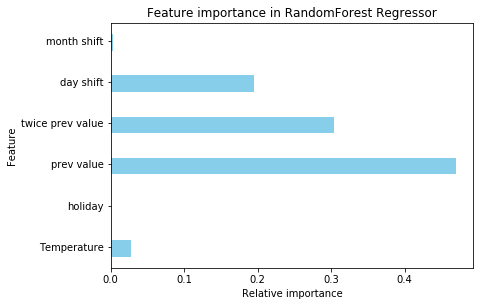

<Figure size 360x360 with 0 Axes>

In [34]:

#plot
fig, ax = plt.subplots() 
width = 0.4 # the width of the bars 
ind = np.arange(len(importances)) # the x locations for the groups
ax.barh(ind, importances, width, color='skyblue')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(feature_list, minor=False)
plt.title('Feature importance in RandomForest Regressor')
plt.xlabel('Relative importance')
plt.ylabel('Feature') 
plt.figure(figsize=(5,5))
fig.set_size_inches(6.5, 4.5, forward=True)
plt.savefig('feature_imp.jpeg')

In [ ]:
tr['pred'] = tr_pred
te['pred'] = te_pred

te.to_csv('test_predictions.csv')
tr.to_csv('train_predictions.csv')